# Examining F_s across the globe

In [45]:
# imports
from importlib import reload
import numpy as np
import xarray

from matplotlib import pyplot as plt

from ulmo import io as ulmo_io
from ulmo.llc import io as llc_io 
from ulmo.llc import kinematics
from ulmo.plotting import plotting

# Init

In [30]:
field_size = 64

# Load up the table

In [3]:
LLC_FS_file = 's3://llc/Tables/LLC_FS_r1.0.parquet'
llc_table = ulmo_io.load_main_table(LLC_FS_file)

Read main table: s3://llc/Tables/LLC_FS_r1.0.parquet


In [4]:
llc_table.lon

0        -170.447922
1        -155.677078
2        -155.635422
3        -152.864578
4        -152.114578
             ...    
115960    175.489578
115961    176.489578
115962    177.510422
115963    178.510422
115964    179.510422
Name: lon, Length: 115965, dtype: float32

# Load up the LLC data

In [12]:
ds = xarray.open_dataset(llc_table.iloc[0].filename)
ds

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 ...
    U        (j, i_g) float32 ...
    V        (j_g, i) float32 ...
    W        (k_l, j, i) float32 ...
    Salt     (j, i) float32 ...

## No Lazy

In [14]:
U = ds.U.values
V = ds.V.values
Salt = ds.Salt.values
sst = ds.Theta.values

# Load Coords

In [16]:
coords_ds = llc_io.load_coords()

Loading LLC coords from /data/Projects/Oceanography/data/LLC/LLC_coords.nc


# Defs

## Plot

In [57]:
def sst_Fs_from_cutout(cutout):
    sst_cutout = llc_io.grab_cutout(sst, cutout.row, cutout.col, fixed_km=144., coords_ds=coords_ds)
    U_cutout = llc_io.grab_cutout(U, cutout.row, cutout.col, fixed_km=144., coords_ds=coords_ds)
    V_cutout = llc_io.grab_cutout(V, cutout.row, cutout.col, fixed_km=144., coords_ds=coords_ds)
    Salt_cutout = llc_io.grab_cutout(Salt, cutout.row, cutout.col, fixed_km=144., coords_ds=coords_ds)
    # F_s
    F_s = kinematics.calc_F_s(U_cutout, V_cutout, sst_cutout, Salt_cutout)
    # Resize
    F_s_cutout = kinematics.resize_local_mean(F_s, (field_size, field_size))
    
    # Return
    return sst_cutout, F_s_cutout

## Grab interesting F_s

In [58]:
def grab_fs_cutouts(minlon, maxlon, minlat, maxlat, minNpos=100):
    ex = (llc_table.lon < maxlon) & (llc_table.lon > minlon) & (
        llc_table.lat < maxlat) & (llc_table.lat > minlat) & (
        llc_table.FS_Npos > minNpos)
    return ex

----

# Brazil first

## Grab one

In [62]:
item = 50
ex_brazil = grab_fs_cutouts(minlon=-60., maxlon=-30., minlat=-60, maxlat=-30.)
# Grab it
i_brazil = np.where(ex_brazil)[0][item]
brazil_cutout = llc_table.iloc[i_brazil]
brazil_cutout

lat                                                        -36.058659
lon                                                        -47.114582
row                                                              5872
col                                                             16810
datetime                                          2011-09-30 00:00:00
filename            /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file                            s3://llc/PreProc/LLC_FS_preproc.h5
pp_root                                                        llc_FS
field_size                                                         64
pp_idx                                                          99035
pp_type                                                             0
mean_temperature                                            15.862472
Tmin                                                           11.578
Tmax                                                           17.809
T90                 

## Grab data cutouts

In [60]:
sst_cutout, F_s_cutout = sst_Fs_from_cutout(brazil_cutout)

## Plot

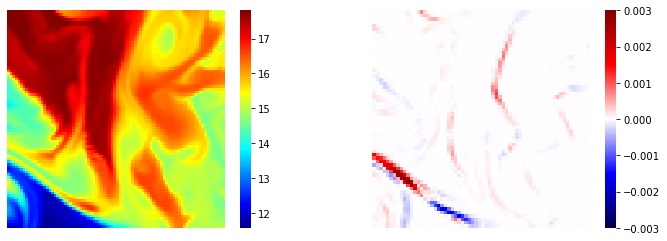

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
plotting.show_image(sst_cutout, set_aspect='equal', ax=ax1)
plotting.show_image(F_s_cutout, set_aspect='equal', vmnx=(-3e-3,3e-3), cm='seismic', ax=ax2)
plt.show()

----

# Off the West of Australia

In [63]:
item = 50
ex_Waussie = grab_fs_cutouts(minlon=90., maxlon=100., minlat=-30, maxlat=-15.)
# Grab it
i_Waussie = np.where(ex_Waussie)[0][item]
Waussie_cutout = llc_table.iloc[i_Waussie]
Waussie_cutout

lat                                                         -18.51581
lon                                                         99.135414
row                                                              6908
col                                                              6550
datetime                                          2011-09-30 00:00:00
filename            /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file                            s3://llc/PreProc/LLC_FS_preproc.h5
pp_root                                                        llc_FS
field_size                                                         64
pp_idx                                                          74560
pp_type                                                             0
mean_temperature                                            24.412111
Tmin                                                        23.415001
Tmax                                                        25.120001
T90                 

## Grab and plot

In [64]:
sst_cutout, F_s_cutout = sst_Fs_from_cutout(Waussie_cutout)

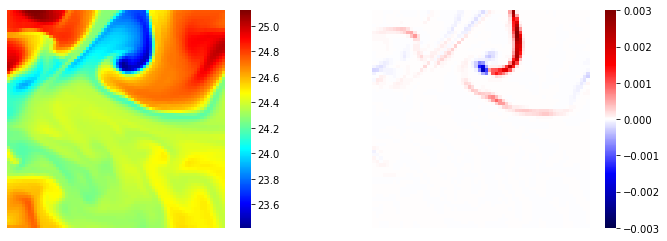

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
plotting.show_image(sst_cutout, set_aspect='equal', ax=ax1)
plotting.show_image(F_s_cutout, set_aspect='equal', vmnx=(-3e-3,3e-3), cm='seismic', ax=ax2)
plt.show()

----

# South Pacific

In [66]:
item = 50
ex_SPacific = grab_fs_cutouts(minlon=-180., maxlon=-150., minlat=-30, maxlat=-15.)
# Grab it
i_SPacific = np.where(ex_SPacific)[0][item]
SPacific_cutout = llc_table.iloc[i_SPacific]
SPacific_cutout

lat                                                        -21.699188
lon                                                       -179.989578
row                                                              6731
col                                                             10432
datetime                                          2011-09-30 00:00:00
filename            /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file                            s3://llc/PreProc/LLC_FS_preproc.h5
pp_root                                                        llc_FS
field_size                                                         64
pp_idx                                                         105338
pp_type                                                             0
mean_temperature                                            23.355892
Tmin                                                        22.067001
Tmax                                                           24.361
T90                 

## Grab and plot

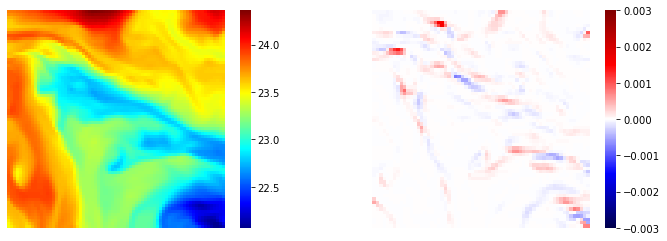

In [67]:
sst_cutout, F_s_cutout = sst_Fs_from_cutout(SPacific_cutout)
#
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
plotting.show_image(sst_cutout, set_aspect='equal', ax=ax1)
plotting.show_image(F_s_cutout, set_aspect='equal', vmnx=(-3e-3,3e-3), cm='seismic', ax=ax2)
plt.show()